In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np


netflix_df = pd.read_csv('netflix.csv')

In [ ]:
netflix_df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
5,2018-02-12,252.139999,259.149994,249.000000,257.950012,257.950012,8534900
6,2018-02-13,257.290009,261.410004,254.699997,258.269989,258.269989,6855200
7,2018-02-14,260.470001,269.880005,260.329987,266.000000,266.000000,10972000
8,2018-02-15,270.029999,280.500000,267.630005,280.269989,280.269989,10759700
9,2018-02-16,278.730011,281.959991,275.690002,278.519989,278.519989,8312400


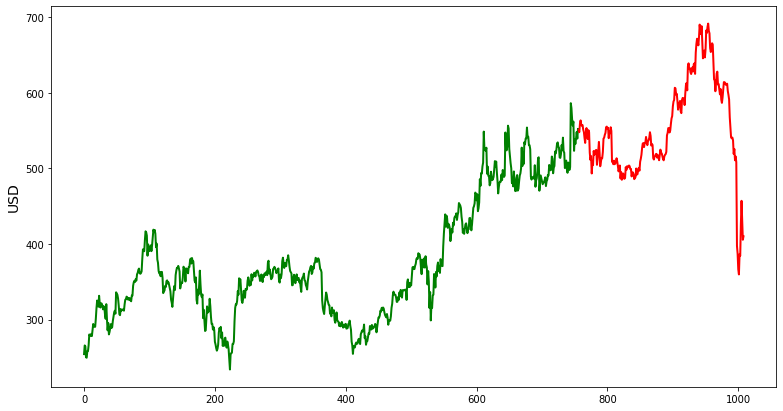

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_size = int(len(netflix_df) * 0.75)
test_size = int(len(netflix_df) - train_size)

train_data = netflix_df[0:train_size]
test_data = netflix_df[train_size:]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw, color='g')
    ax.plot(line2, label=label2, linewidth=lw, color='r')
    ax.set_ylabel('USD', fontsize=14)
    ax.set_title(title, fontsize=16)
    # ax.legend(loc='best', fontsize=16);
    plt.ion()

line_plot(train_data['Close'], test_data['Close'], 'training', 'test', title='')

In [ ]:
# LSTM is sensitive to scale data so we need to apply the MinMax Sclar for preprocess the data
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(0,1)) # Here feature_range means convert the data point to range between 0 to 1
close_df = minmaxscaler.fit_transform(np.array(netflix_df['Close']).reshape(-1,1)) # Here reshape is should be used for LSTM

In [ ]:
close_df.shape

(1009, 1)

In [ ]:
train_size = int(len(close_df) * 0.75)
test_size = int(len(close_df) - train_size)

In [ ]:
train_size, test_size

(756, 253)

In [ ]:
train_data = close_df[0:train_size]
test_data = close_df[train_size:]

In [ ]:
# convert the data array to data set matrix with time step 

''' 
  If Time step is '4' then X contains for '0' iteration ======> 0,1,2,3 and Y will be 4

  Example For following Function

  '0' iteration:
  ------------------
    X =================> 0:0+4 => 0:4 => 0,1,2,3
    Y =================> 0+4   => 4   => 4
'''

def MakedataSet(dataset=None, timestep=None):
  dataX,dataY= [],[]
  for i in range(len(dataset)-timestep-1):
    dataX.append(dataset[i:(i+timestep), 0]) 
    dataY.append(dataset[i + timestep, 0]) 
  return np.array(dataX), np.array(dataY)

In [ ]:
timestep= 75
X_train, Y_train = MakedataSet(train_data, timestep)
x_test, y_test = MakedataSet(test_data, timestep)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
# Create the Staked LSTM-RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(75,1)))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 75, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 75, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 75, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trai

In [ ]:
model_fit_history = model.fit(X_train,Y_train,validation_data=(x_test,y_test),epochs=50,batch_size=32,verbose=1)

Epoch 1/50
22/22 [==============================] - 68s 188ms/step - loss: 0.0279 - val_loss: 0.0193
Epoch 2/50
22/22 [==============================] - 2s 111ms/step - loss: 0.0070 - val_loss: 0.0179
Epoch 3/50
22/22 [==============================] - 2s 111ms/step - loss: 0.0052 - val_loss: 0.0086
Epoch 4/50
22/22 [==============================] - 2s 113ms/step - loss: 0.0044 - val_loss: 0.0165
Epoch 5/50
22/22 [==============================] - 2s 111ms/step - loss: 0.0045 - val_loss: 0.0118
Epoch 6/50
22/22 [==============================] - 2s 111ms/step - loss: 0.0045 - val_loss: 0.0072
Epoch 7/50
22/22 [==============================] - 2s 111ms/step - loss: 0.0044 - val_loss: 0.0082
Epoch 8/50
22/22 [==============================] - 2s 110ms/step - loss: 0.0049 - val_loss: 0.0112
Epoch 9/50
22/22 [==============================] - 2s 110ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 10/50
22/22 [==============================] - 2s 110ms/step - loss: 0.0047 - val_loss: 0.007

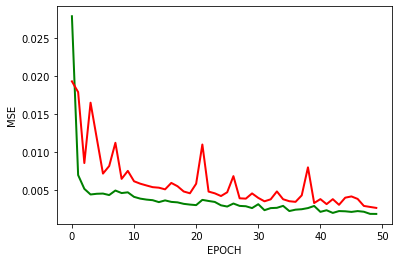

In [ ]:
plt.plot(model_fit_history.history['loss'], 'g', linewidth=2, label='Training Loss')
plt.plot(model_fit_history.history['val_loss'], 'r', linewidth=2, label='Training Loss')
plt.xlabel('EPOCH')
plt.ylabel('MSE')
plt.show()

In [ ]:
# Let's Do the Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(x_test)

In [ ]:
#Transformback to original form
train_predict=minmaxscaler.inverse_transform(train_predict)
test_predict=minmaxscaler.inverse_transform(test_predict)

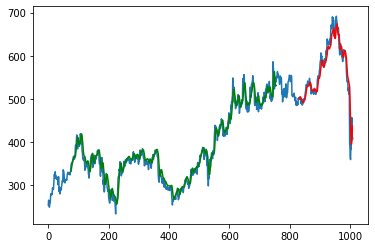

In [ ]:
# ## Plotting 
# shift train predictions for plotting
look_back=75
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(minmaxscaler.inverse_transform(close_df))
plt.plot(trainPredictPlot, 'g')
plt.plot(testPredictPlot, 'r')
plt.show()

In [ ]:
model.save('netflix_model.h5')

In [ ]:
import joblib
scaler_filename = "scaler.pkl"
joblib.dump(minmaxscaler, scaler_filename) 


['/content/drive/My Drive/Datasets/netflix/scaler.pkl']